In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#During submission internet is disabled. Hence install this package manually
!pip install -qU ../input/for-pydicom/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl --find-links frozen_packages --no-index

In [3]:
import pandas as pd
import numpy as np
import pydicom as dicom
import glob
import nibabel as nib
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
base_dir = r'/kaggle/input/rsna-2022-cervical-spine-fracture-detection'
train_images = os.path.join(base_dir,'train_images')
test_images = os.path.join(base_dir,'test_images')
segmentation_data = r'/kaggle/input/rsna-cervical-fracture-segmentations-npy/npy_segmentations'
train_data = pd.read_csv(os.path.join(base_dir,'train.csv'))
segmentation_meta_data = pd.read_csv(r'/kaggle/input/rsna-cervical-fracture-segmentation-metadata/meta_segmentation.csv')


In [5]:
segmentation_meta_data.shape

(29832, 26)

In [6]:
segmentation_meta_data.columns

Index(['Rows', 'Columns', 'SOPInstanceUID', 'ContentDate', 'SliceThickness',
       'InstanceNumber', 'ImagePositionPatientX', 'ImagePositionPatientY',
       'ImagePositionPatientZ', 'PhotometricInterpretation', 'PixelSpacingX',
       'PixelSpacingY', 'WindowCenter', 'WindowWidth', 'RescaleIntercept',
       'RescaleSlope', 'StudyInstanceUID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'Slice', 'SliceRatio'],
      dtype='object')

In [7]:
columns = ['StudyInstanceUID','SOPInstanceUID','C1','C2','C3','C4','C5','C6','C7']

In [8]:
seg_labels = segmentation_meta_data[columns]

In [9]:
seg_labels.head(2)

,StudyInstanceUID,SOPInstanceUID,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.12,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363.1.120,0,0,0,0,1,1,0


In [10]:
#Get Slice instance number
seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1:][0])

/tmp/ipykernel_26/2062957656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_labels.loc[:,'slice'] = seg_labels['SOPInstanceUID'].apply(lambda x:x.split('.')[-1:][0])


In [11]:
def load_dicom(path):
    '''Function to load and transform DICOM images'''
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)        
    return cv2.cvtColor(data.reshape(512, 512), cv2.COLOR_GRAY2RGB)

In [12]:
def ImgDataGenerator(train_df,base_path):
        '''Function to read dicom image path and store the images as numpy arrays'''
        trainset = []
        trainlabel = []
        for i in tqdm(range(len(train_df))):
            study_id = train_df.loc[i,'StudyInstanceUID']
            slice_id = train_df.loc[i,'slice']+'.dcm'
            study_path = study_id+'/'+slice_id
            
            path = os.path.join(base_path, study_path)
      
                #dc = dicom.read_file(os.path.join(path,im))
            #if dc.file_meta.TransferSyntaxUID.name =='JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])':
            #    continue
            img = load_dicom(path)
            img = cv2.resize(img, (128 , 128))
            image = img_to_array(img)
            image = image / 255.0
            trainset += [image]
            cur_label = [train_df.loc[i,f'C{j}'] for j in range(1,8)]
            trainlabel += [cur_label]

                         
                
        return np.array(trainset), np.array(trainlabel)


In [13]:
def RSNAImgArrayGenerator(ids,base_path):
    '''Function to generate numpy array for test dataset'''
           
    testset=[]
    for id in tqdm(ids):        
        path = os.path.join(base_path, id)
        if os.path.exists(path):
            for im in (os.listdir(path)):
                dc = dicom.read_file(os.path.join(path,im))
                img=load_dicom(os.path.join(path,im))
                img=cv2.resize(img,(128, 128))
                image=img_to_array(img)
                image=image/255.0
                testset+=[image]
    return np.array(testset)


In [14]:
#Get list of study ids who doesn't have segmentation data
non_seg_train_ids = [id for id in train_data['StudyInstanceUID'].unique() if id not in seg_labels['StudyInstanceUID'].unique()]

In [15]:
len(non_seg_train_ids)

1932

In [16]:
#non_seg_training_data = RSNAImgArrayGenerator(non_seg_train_ids,train_images)

In [17]:
#Fetch training data for study ids who doesn't have segmentation images
non_seg_train_data = train_data[train_data['StudyInstanceUID'].isin(non_seg_train_ids)]

In [18]:
non_seg_train_data.head(2)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0


In [19]:
#Convert train images of segmented studyids to array
X_seg,y_seg = ImgDataGenerator(seg_labels,train_images)

100%|██████████| 29832/29832 [08:37<00:00, 57.64it/s]


In [20]:
#save for future use
np.save('/kaggle/working/seg_train_images.npy',X_seg)
np.save('/kaggle/working/seg_train_images_labels.npy',y_seg)

In [21]:
#Uncomment this if you want to use the above output in the next run
#X_seg = np.load(r'/kaggle/input/identify-vertbrae-using-cnn/seg_train_images.npy')
#y_seg = np.load(r'/kaggle/input/identify-vertbrae-using-cnn/seg_train_images_labels.npy')

In [22]:
print(X_seg.shape,y_seg.shape)

(29832, 128, 128, 3) (29832, 7)


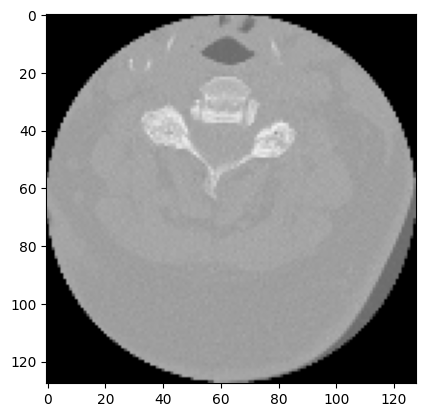

In [23]:
#Visualize a random CT scan image
import matplotlib.pyplot as plt
plt.imshow(X_seg[500], cmap = 'bone')

In [24]:
#Find its segmentation value. 
y_seg[500]
#The above slice represents cervicals C3 and C4

array([0, 0, 1, 1, 0, 0, 0])

In [25]:
def get_basic_cnn():
    
    '''Basic Convolutional Neural Network to train segmentation CT scan images'''
    
    
    inp = tfl.Input((128, 128 ,3))
    x = tfl.Conv2D(32, (3, 3), activation='relu')(inp)
    x = tfl.MaxPooling2D((2, 2))(x)
    x = tfl.Conv2D(64, (3, 3), activation='relu')(inp)
    x = tfl.MaxPooling2D((2, 2))(x)
    x = tfl.Conv2D(128, (3, 3), activation='relu')(inp)
    x = tfl.MaxPooling2D((2, 2))(x)
    x = tfl.Flatten()(x)
    x = tfl.Dense(128, 'relu')(x)
    x = tfl.Dropout(0.5)(x)
    out = tfl.Dense(7, 'sigmoid')(x)
    
    model = tf.keras.models.Model(inp, out)
    
    model.compile(loss="binary_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
    model.summary()
    
    return model

#recall, precision. Way to use softmax [1,0,0,0,1,0,0] -> [0.5,0,0,0,0.5,0,0]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_seg, y_seg, random_state=42, test_size=0.1)

In [27]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(26848, 128, 128, 3) (26848, 7)
(2984, 128, 128, 3) (2984, 7)


In [28]:
model = get_basic_cnn()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 508032)            0         
                                                                 
 dense (Dense)               (None, 128)               65028224  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

In [29]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/10
420/420 [==============================] - 24s 36ms/step - loss: 0.3887 - binary_accuracy: 0.8359 - val_loss: 0.2913 - val_binary_accuracy: 0.8637
Epoch 2/10
420/420 [==============================] - 14s 34ms/step - loss: 0.3030 - binary_accuracy: 0.8662 - val_loss: 0.2449 - val_binary_accuracy: 0.8863
Epoch 3/10
420/420 [==============================] - 14s 34ms/step - loss: 0.2614 - binary_accuracy: 0.8819 - val_loss: 0.2096 - val_binary_accuracy: 0.9057
Epoch 4/10
420/420 [==============================] - 14s 34ms/step - loss: 0.2284 - binary_accuracy: 0.8975 - val_loss: 0.1789 - val_binary_accuracy: 0.9202
Epoch 5/10
420/420 [==============================] - 14s 34ms/step - loss: 0.2040 - binary_accuracy: 0.9102 - val_loss: 0.1546 - val_binary_accuracy: 0.9411
Epoch 6/10
420/420 [==============================] - 14s 34ms/step - loss: 0.1840 - binary_accuracy: 0.9200 - val_loss: 0.1397 - val_binary_accuracy: 0.9424
Epoch 7/10
420/420 [==============================] 

In [30]:
y_hat = model.predict(X_test)

94/94 [==============================] - 1s 7ms/step


In [31]:
score = model.evaluate(X_test, y_test, verbose = 1)

94/94 [==============================] - 1s 8ms/step - loss: 0.0891 - binary_accuracy: 0.9747


In [32]:
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.08914126455783844
Test accuracy: 0.9746744632720947


In [33]:
classes = np.array(seg_labels.columns[2:-1])
img = X_test[17]

proba = model.predict(img.reshape(1,128,128,3))

1/1 [==============================] - 0s 34ms/step


In [34]:
#Fetches the probability value for each class in a sorted order
np.argsort(proba[0]) 

array([3, 4, 2, 1, 5, 0, 6])

In [35]:
#When I try to generate non_seg_image array for predictions, the notebook ran out of memory. Will be
#fixed in future iteration

# non_seg_data = train_data[~train_data['StudyInstanceUID'].isin(seg_labels['StudyInstanceUID'])]

# X_non_seg = RSNADFGenerator(non_seg_data,train_images)

In [36]:
#Code for future purpose 
# accuracies=[]
# for train_idx, val_idx in StratifiedKFold(5).split(df_train, df_train['patient_overall']):    
#     K.clear_session()
#     x_train = df_train.iloc[train_idx].reset_index()
#     x_val = df_train.iloc[val_idx].reset_index()

#     train_gen = RSNATrainGenerator(x_train, min(len(x_train), 64), infinite = False, base_path = train_images_dir)
#     val_gen = RSNATrainGenerator(x_val, min(len(x_val), 64), infinite = False, base_path = train_images_dir)

#     model = get_basic_cnn()
#     print("validation steps: ",(len(x_val) // 64), "steps_per_epoch: ",(len(x_train) // 64))

#     hist = model.fit(                            
#         train_gen,
#         epochs = 5,
#         callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)],
#         validation_steps = max((len(x_val) // 64), 1),
#         steps_per_epoch = max((len(x_train) // 64), 1),
#         validation_data = val_gen
#       )

#     #hist2 = model2.fit_generator(                            
#     #    train_gen,
#     #    epochs = 5,
#     #    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)],
#     #    validation_steps = max((len(x_val) // 64), 1),
#     #    steps_per_epoch = max((len(x_train) // 64), 1),
#     #    validation_data = val_gen,
#     #  )
#     accuracies.append(model.evaluate(val_gen, steps = max((len(x_val) // 64), 1))[1])

In [37]:
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)